# Introduction 👋🏼
__The Goal__ - Develop an unsupervised learning approach to group patent claims into distinct topics.</br>
In this notebook I will show various approaches for the goal:</br>
1. **K-Means**: K-means is a simple technique for grouping data. It forms clusters of data points that are alike, making sure each group's center (centroid) is positioned to keep the group as tight as possible.

2. **Hierarchical Clustering**: This method sorts data into a tree-like structure of clusters. It starts by treating each data point as its own cluster and then gradually merges them into larger and larger clusters based on how close they are to each other.

3. **GPT-2 Embeddings with K-means**: This approach uses GPT-2, a tool that understands language, to turn text into numerical data. It then applies K-means to organize these texts into groups that have similar meanings.


Websites:
1. https://www.displayr.com/understanding-cluster-analysis-a-comprehensive-guide/
2. https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
3. https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93
4. https://medium.com/@danielafrimi/text-clustering-using-nlp-techniques-c2e6b08b6e95
5. https://vitalflux.com/find-topics-of-text-clustering-python-examples/
6. https://spotintelligence.com/2023/01/17/text-clustering-algorithms/

# Data Exploring

## 1. Data fetching and preprocessing

In [100]:
import pandas as pd

# Load data
csv_data_path = './data_files/normalized_patent_claims.csv'
df = pd.read_csv(csv_data_path)

In [101]:
# Display first 5 rows and shape
print(f"Shape of dataframe: {df.shape}")
df.head()

Shape of dataframe: (61, 2)


,Patent URL,Normalized Claim
0,https://patents.google.com/patent/GB2478972A/e...,claim wireless telephone comprising handset on...
1,https://patents.google.com/patent/GB2478972A/e...,ftirther comprising body cradle handset onloff...
2,https://patents.google.com/patent/GB2478972A/e...,ftirther comprising call receiving mean receiv...
3,https://patents.google.com/patent/GB2478972A/e...,first predetermined button redial button
4,https://patents.google.com/patent/GB2478972A/e...,transfer mean toggle first call putting either...


In [102]:
# Check for missing values
missing_data = df['Normalized Claim'].isnull().sum()
print(f"Number of missing values in 'normalized_claims': {missing_data}")

Number of missing values in 'normalized_claims': 0


In [103]:
# Function to count unique words
def count_unique_words(df: pd.DataFrame):
    # Initialize an empty set to store unique words
    unique_words = set()

    # Iterate over each normalized claim in the DataFrame
    for claim in df['Normalized Claim']:
        
        # Split the claim into words and update the set
        words = claim.split()
        unique_words.update(words)
    
    return unique_words

print(f"There are {len(count_unique_words(df))} unique words.")

There are 243 unique words.


In [104]:
from scipy import sparse

# Load the TF-IDF matrix
matrix_path = './data_files/tfidf_matrix.npz'
tfidf_matrix = sparse.load_npz(matrix_path)

# Show the shape of the matrix
print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")

Shape of TF-IDF matrix: (61, 243)


For the above, I wanted to check if the dimensions of the matrix and the unique words from the DataFrame are equal.

## 2. Experiment Models

### 2.1 K-Means using TF-IDF

In [105]:
# Import necessary libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### 2.1.1 Elbow Method
Used to determine the optimal number of clusters by plotting SSE and looking for the 'elbow point'.</br>In the graph below it's around 6-7 clusters. </br>

In [106]:
sse = [] # Sum of squared errors
n = 11 # Number of clusters

# Initialize and fit K-Means
for k in range (1, n):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)

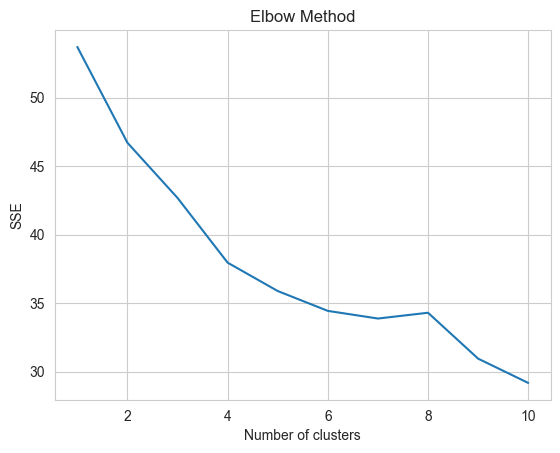

In [107]:
# Plotting
sns.set_style("whitegrid")
g = sns.lineplot(x=range(1, n), y=sse)

g.set(xlabel="Number of clusters", ylabel="SSE", title='Elbow Method')

plt.show()

#### 2.1.2 K-Means Implementation

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Principal Component Analysis for dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Silhouette Score - measure of how well each data point fits into its cluster
from scipy.sparse import csr_matrix # Compressed Sparse Row - used for sparse matrices

def cluster_and_visualize(tfidf_matrix: csr_matrix, k: int):
    """
    Cluster the given TF-IDF matrix using K-Means and visualize the clusters.
    
    Parameters:
    tfidf_matrix (csr_matrix): The TF-IDF matrix to be clustered in csr format.
    k (int): The number of clusters to create.
    
    Returns:
    None. The function only prints the average silhouette score for each cluster and visualizes the clusters in a 2D plot.
    """
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Retrieve the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"For {k} clusters, the average silhouette score is: {100*silhouette_avg:.2f}%")
    
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2) # Set PCA to 2D
    reduced_features = pca.fit_transform(tfidf_matrix.toarray()) # Transform the TF-IDF matrix to 2D
    centroids = kmeans.cluster_centers_
    reduced_centroids = pca.transform(centroids) # Transform the centroids to 2D
    
    # Create a color map
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(colors):
        plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], 
                    color=color, label=f'Cluster {i}', alpha=1)

    # Plot centroids
    plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], marker='x', s=150, c='black', label='Centroids')
    plt.title(f'2D PCA of {k} Clusters with Centroids')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(loc='best')
    plt.show()

For 2 clusters, the average silhouette score is: 12.71%


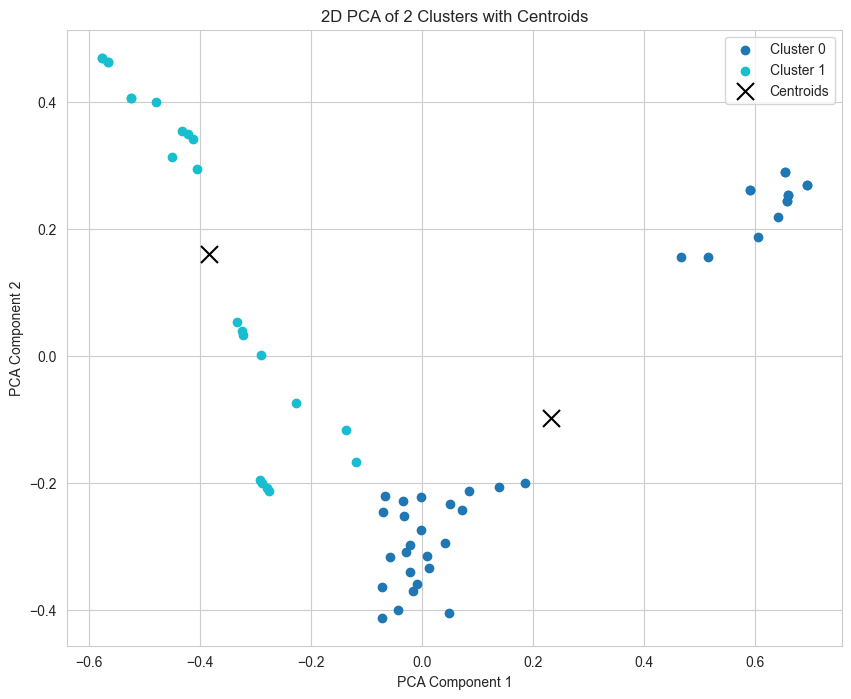

For 3 clusters, the average silhouette score is: 15.41%


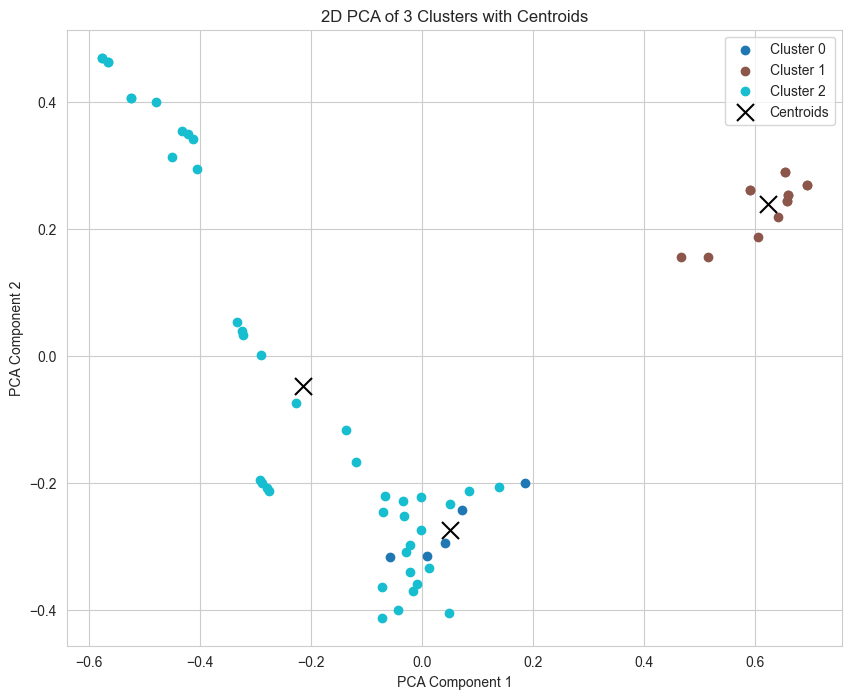

For 4 clusters, the average silhouette score is: 19.45%


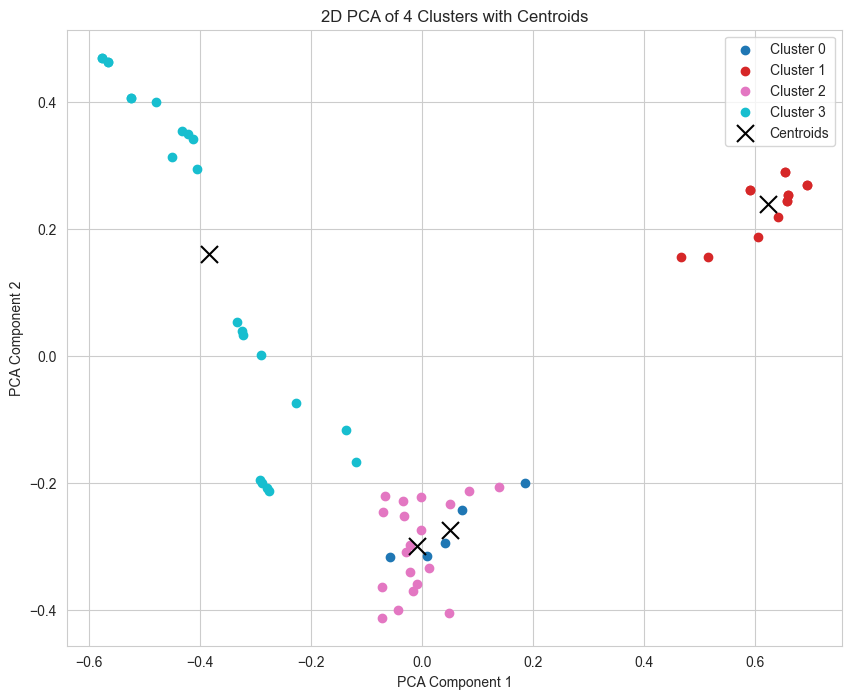

For 5 clusters, the average silhouette score is: 18.24%


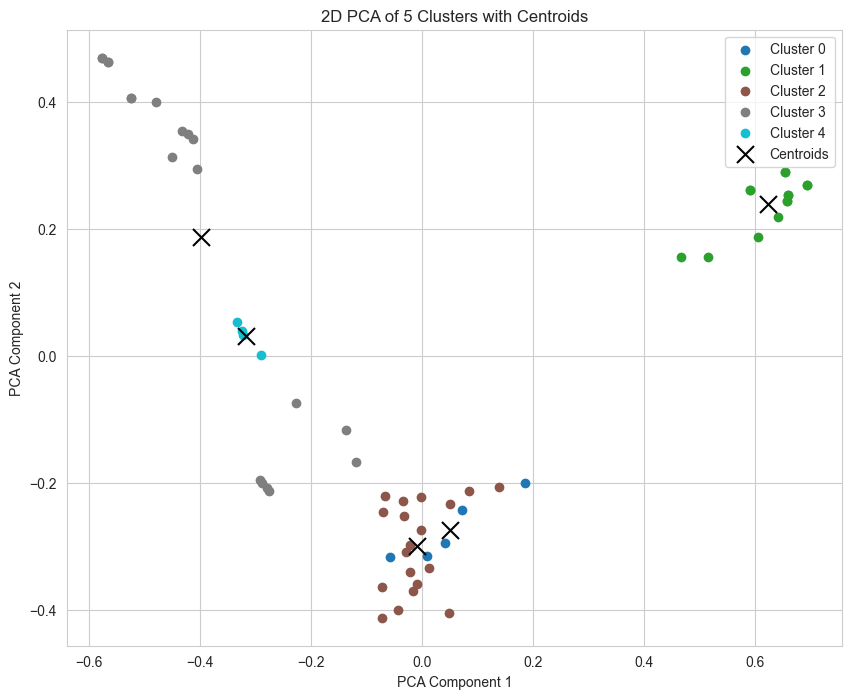

For 6 clusters, the average silhouette score is: 18.94%


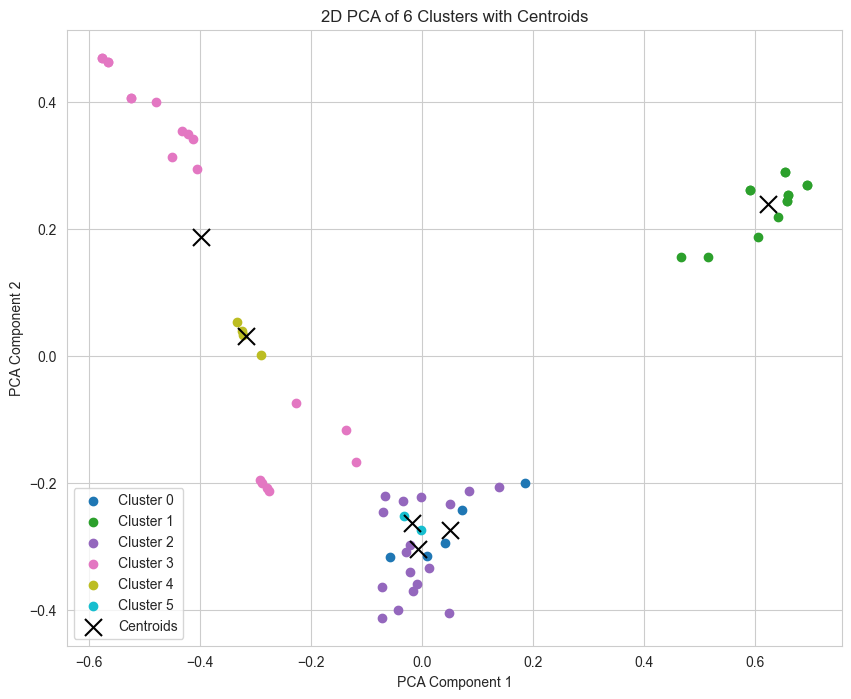

For 7 clusters, the average silhouette score is: 14.20%


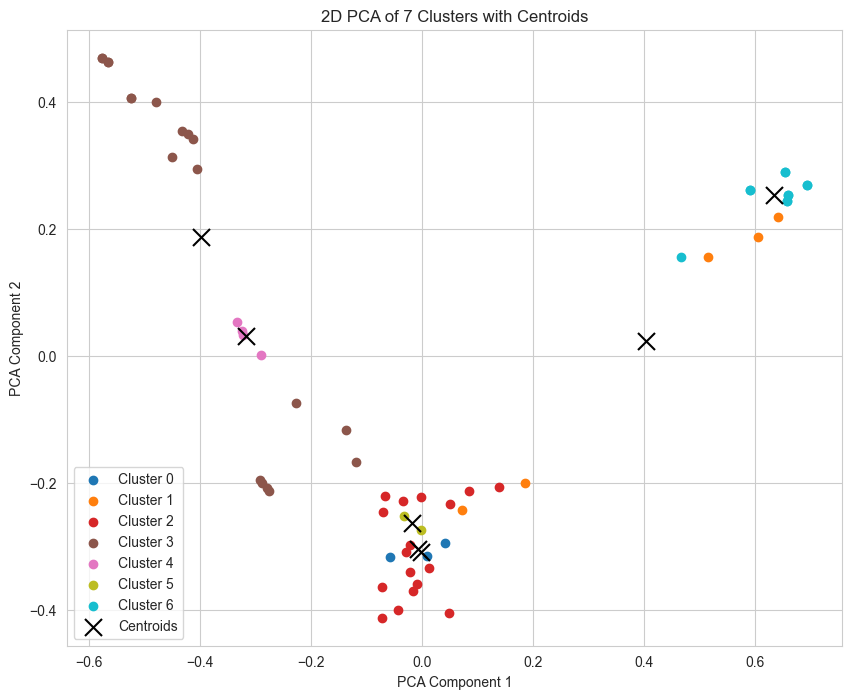

In [109]:
# Cluster and visualize
for i in range(2, 8):
    cluster_and_visualize(tfidf_matrix, k=i)

Based on these resulst, I'll use `k = 4` for two reasons:</br>
1. The groups distribution is better</br>
2. The silhouette score is not so different from `k = 5, 6`

In [110]:
import os

# The chosen number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Get cluster labels
cluster_labels = kmeans.labels_

# Load original data to attach labels
df = pd.read_csv(csv_data_path)
df['Cluster Label'] = cluster_labels

# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'kmeans_cluster_labels.csv')

# Save the DataFrame for further analysis
df.to_csv(csv_path, index=False)

### 2.2 Hierarchical Clustering

In [111]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.sparse import load_npz
from sklearn.cluster import AgglomerativeClustering

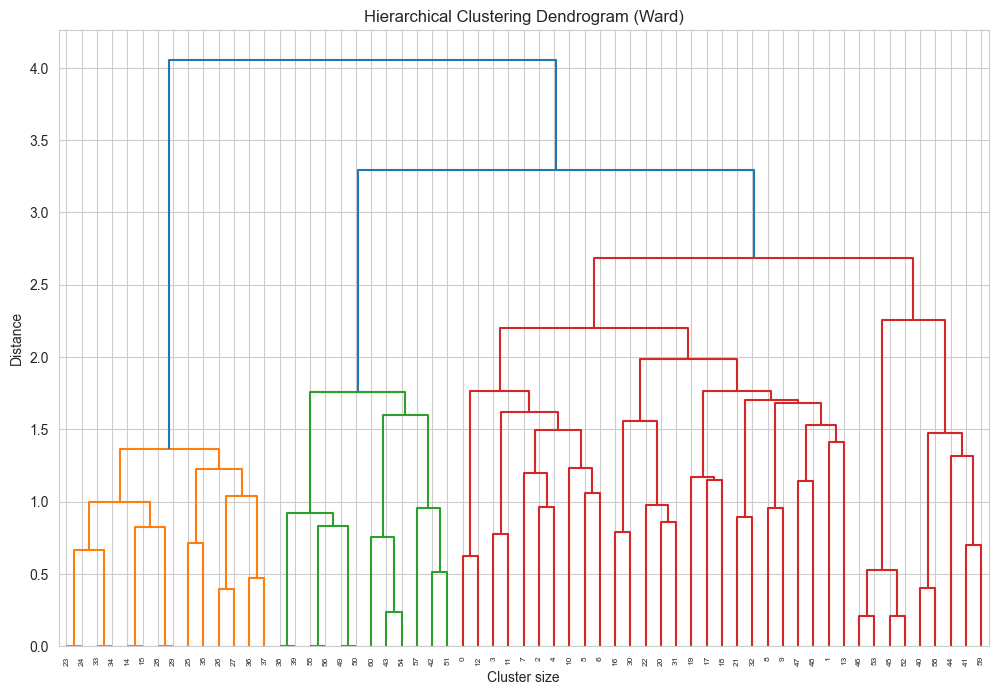

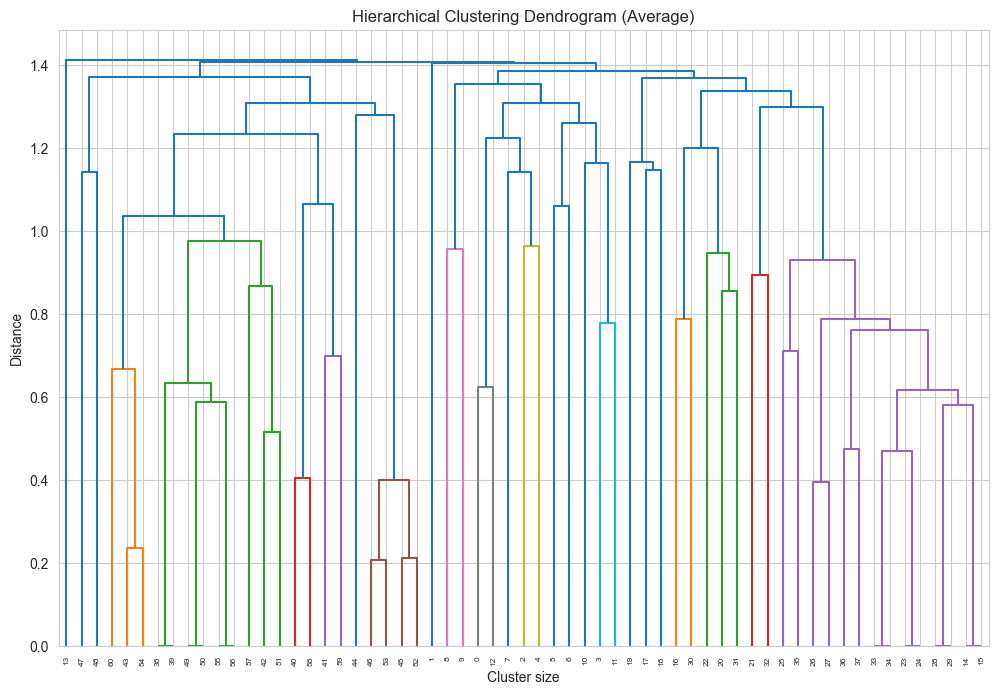

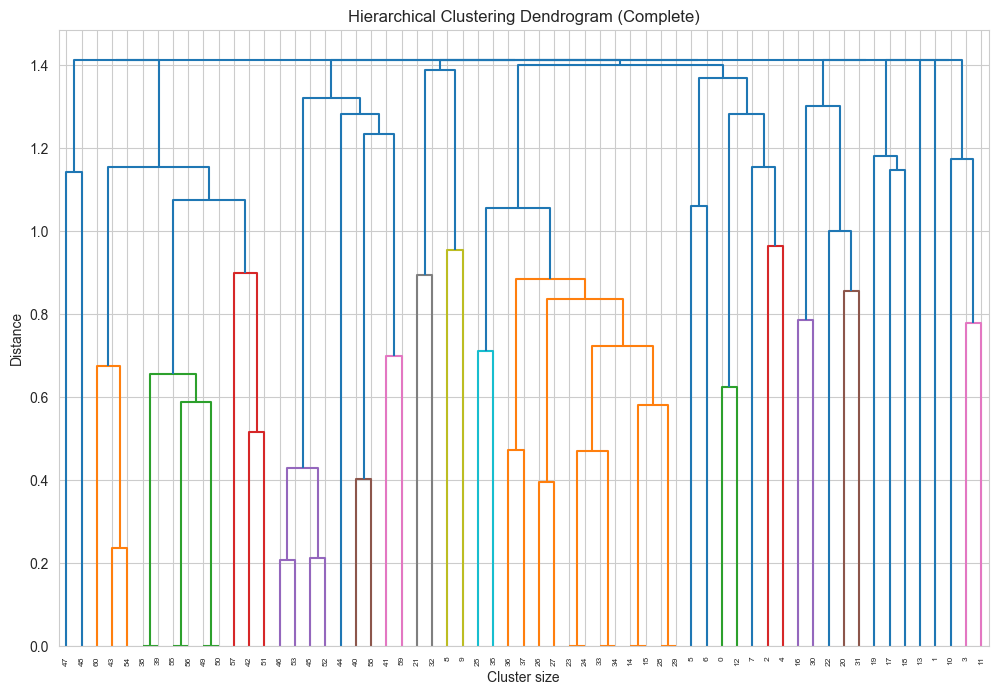

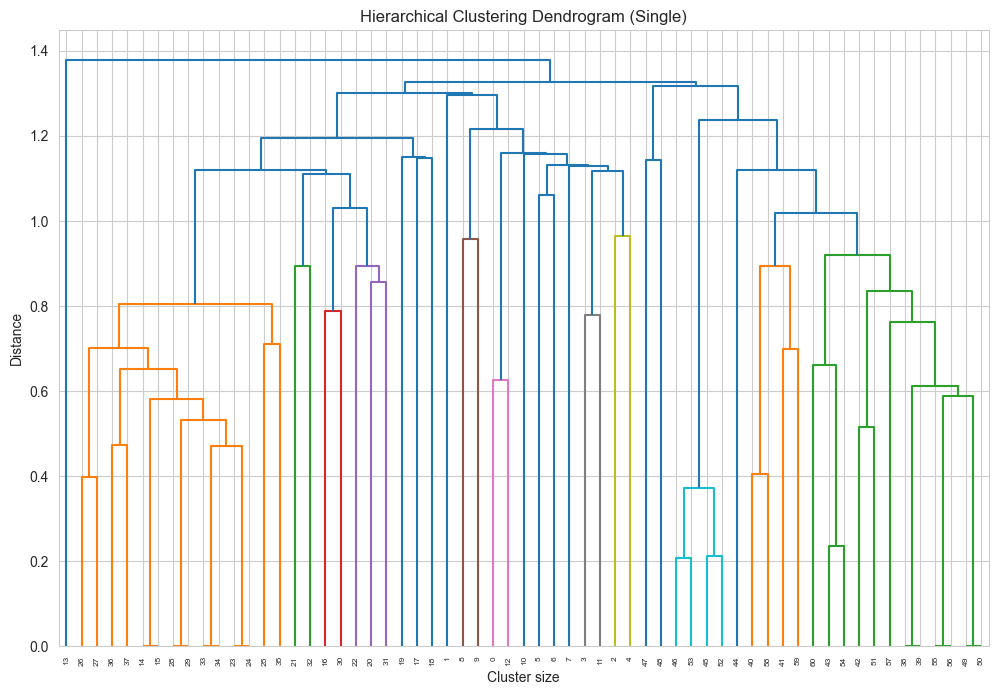

In [112]:
# Load the TF-IDF matrix
tfidf_matrix = load_npz(matrix_path)

# Define the linkage methods
methods = 'ward', 'average', 'complete', 'single'

# Iterate over the linkage methods
for method in methods:
    
    # Compute the linkage matrix
    Z = linkage(tfidf_matrix.toarray(), method=method)

    # Plot the dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(Z)
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()})')
    plt.xlabel('Cluster size')
    plt.ylabel('Distance')
    plt.show()

__Linkage__ refers to the criterion used to determine the distance between sets of observations in hierarchical clustering. It is a key component of the algorithm that dictates how the distance between clusters is measured and thus how the clusters are formed.</br></br>
* __Single Linkage__: The distance between two clusters is defined as the shortest distance between points in the two clusters.
* __Complete Linkage__: The distance between two clusters is defined as the longest distance between points in the two clusters.
* __Average Linkage__: The distance between two clusters is the average distance between all pairs of points in the clusters.
* __Ward’s Linkage__: The distance between two clusters is the increase in the total within-cluster variance after merging them.

</br>A __dendrogram__ is a type of tree diagram frequently used to illustrate the arrangement of the clusters produced by hierarchical clustering.</br>
It shows the hierarchical relationship between objects, where each merge of clusters or objects is represented by a node, and the height of the nodes illustrates the distance or dissimilarity between clusters.

Based on the graphs, it will be best to choose the `ward` method thanks to 2-5 distinct vertical lines.


In [113]:
# Cutting the dendrogram and extract the clusters labels
from scipy.cluster.hierarchy import fcluster

# The chosen number of clusters
k = 4

# Apply the fcluster function to cut the dendrogram at the determined number of clusters
cluster_labels = fcluster(Z, k, criterion='maxclust')

# Load original data to attach labels
df = pd.read_csv(csv_data_path)

# Add cluster label to original dataframe
df['Cluster Label'] = cluster_labels

# Group the data by cluster label
grouped_texts = df.groupby('Cluster Label')['Normalized Claim'].apply(list)

# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'hierarchical_cluster_labels.csv')

# Save the DataFrame for further analysis
df.to_csv(csv_path, index=False)

### 2.3 K-Means using GPT Embeddings

In [114]:
# Import necessary libraries
from transformers import GPT2Model, GPT2Tokenizer
import torch

# Load pre-trained model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

/opt/homebrew/Caskroom/miniforge/base/envs/moveoml/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [115]:
# Function to encode text and get embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Take the mean of all token embeddings to get a single embedding vector per text
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [116]:
# Load the dataset
df = pd.read_csv(csv_data_path)

# Attach texts to column 'Normalized Claim'
texts = df['Normalized Claim'].tolist()

# Generate embeddings for each text
embeddings = [get_embeddings(text) for text in texts]

In [117]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def plot_clusters(embeddings, clusters, k):
    """
    Plots the results of K-means clustering using PCA for dimensionality reduction.
    
    Parameters:
    - embeddings: high-dimensional embeddings from GPT-2 or any other model.
    - clusters: cluster labels obtained from K-means.
    """
    # Calculate silhouette score
    sil_score = silhouette_score(embeddings, clusters)
    print(f"Silhouette Score: {100*sil_score:.2f}% for {k} clusters")
    
    # Reduce dimensions using PCA
    reducer = PCA(n_components=2)
    
    # Fit and transform embeddings
    reduced_embeddings = reducer.fit_transform(embeddings)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.8)
    plt.title(f'GPT2 Embeddings 2D PCA with {k} Clusters')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster Label')
    
    # Get unique labels and colors from the plot
    unique_labels = list(set(clusters))
    unique_colors = [scatter.cmap(scatter.norm(label)) for label in unique_labels]
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='', markersize=10) for color in unique_colors]
    
    # Create a legend
    plt.legend(markers, unique_labels, title="Clusters", borderpad=1)
    
    plt.show()


Silhouette Score: 43.20% for 2 clusters


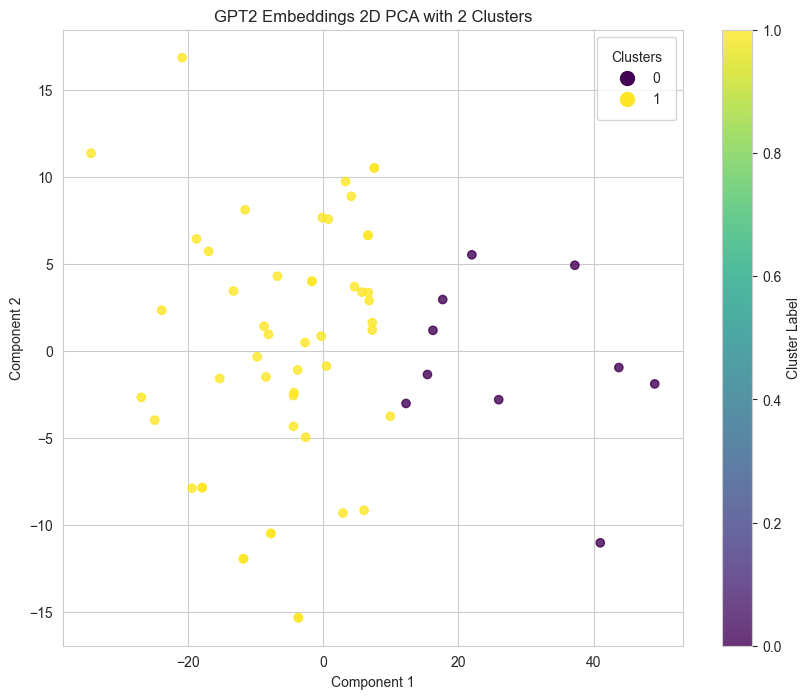

Silhouette Score: 30.05% for 3 clusters


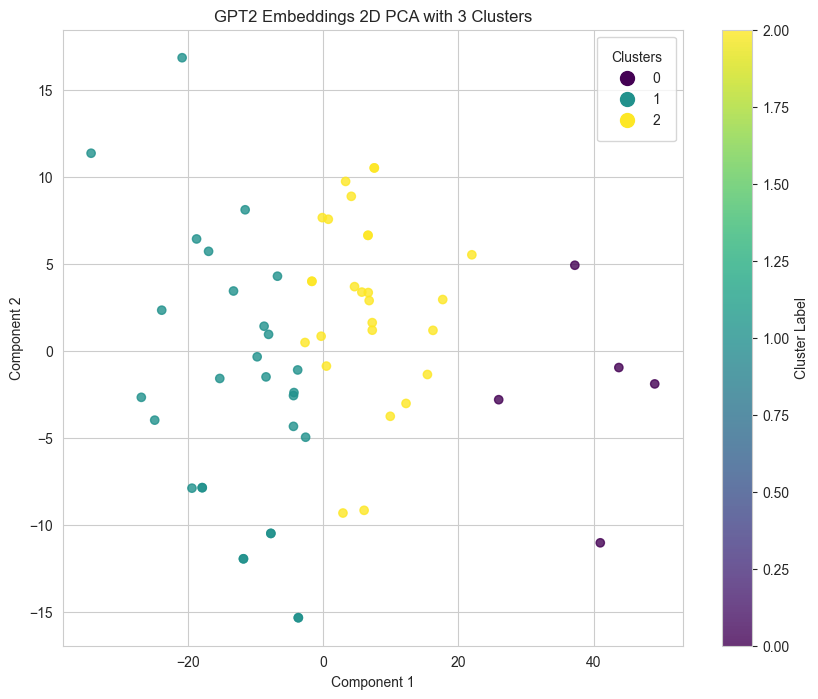

Silhouette Score: 24.50% for 4 clusters


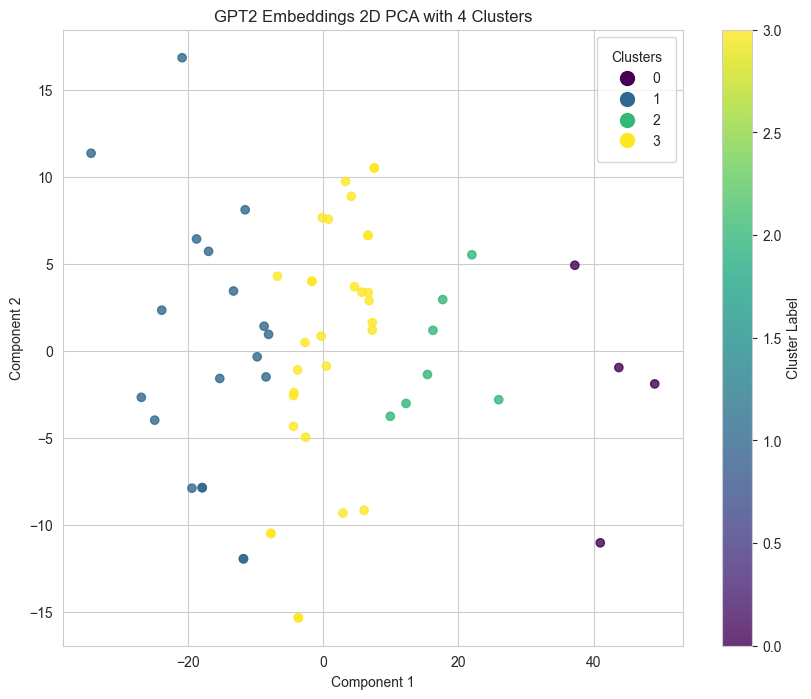

Silhouette Score: 25.51% for 5 clusters


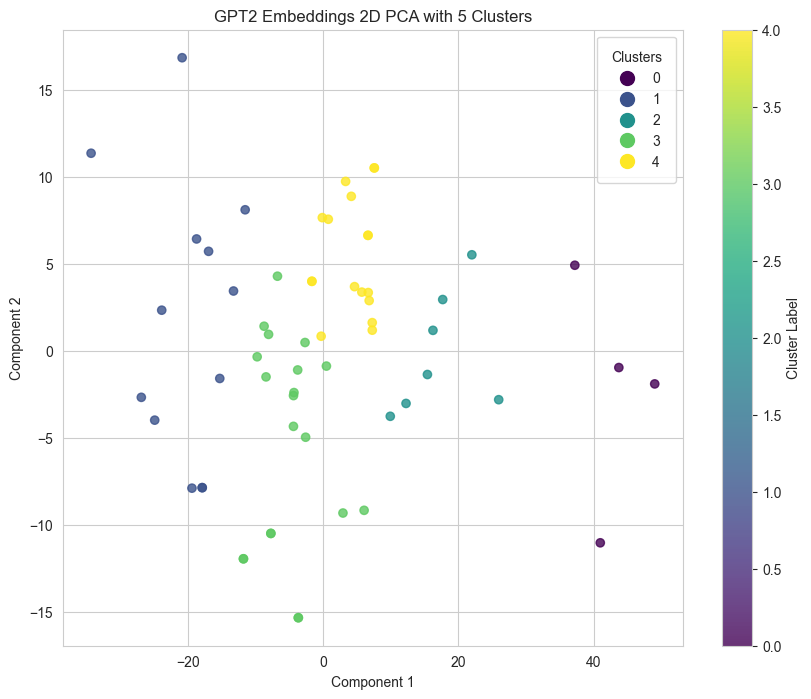

Silhouette Score: 26.35% for 6 clusters


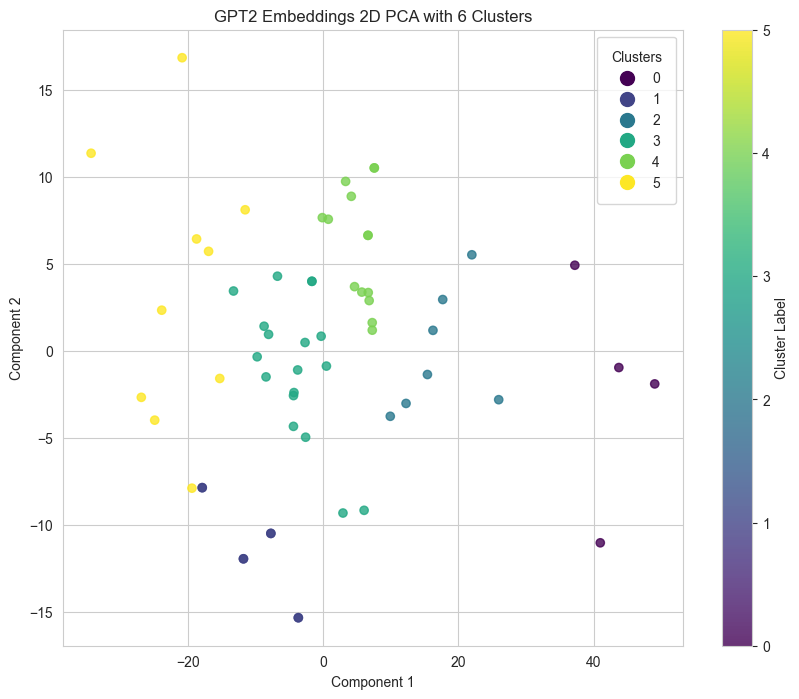

Silhouette Score: 22.53% for 7 clusters


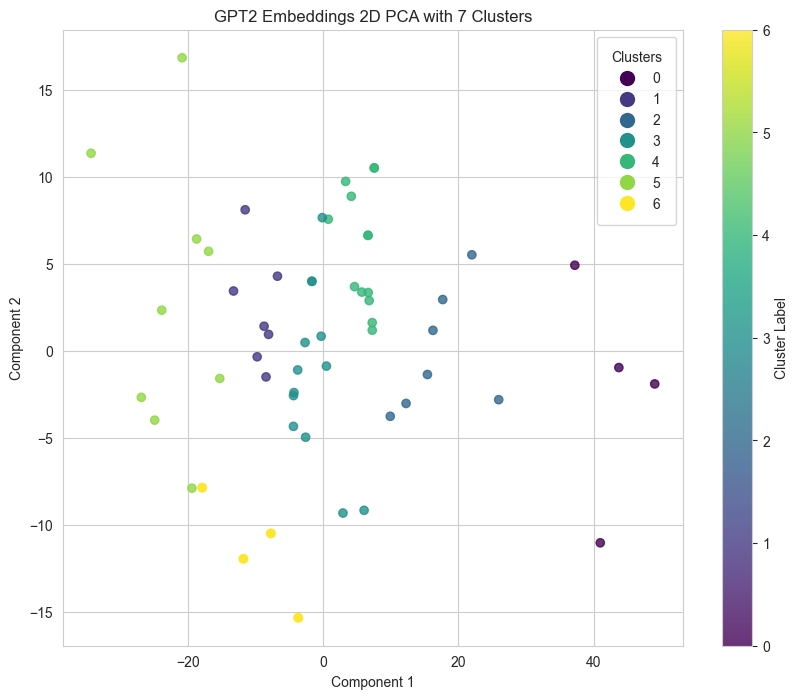

In [118]:
from sklearn.cluster import KMeans

for k in range(2, 8):
    # Clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    clusters = kmeans.labels_

    # Plot the results
    plot_clusters(embeddings, clusters, k)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(embeddings)
clusters = kmeans.labels_

# Add cluster labels back to the original DataFrame
df['Cluster Label'] = clusters

# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'GPT_clustred_patent_claims.csv')

# Save the DataFrame for further analysis
df.to_csv(csv_path, index=False)

# Save the DataFrame with cluster labels if needed
df.to_csv(csv_path, index=False)

### 2.4 Extracting Topics using LDA

Latent Dirichlet Allocation - A statistical model for discovering the abstract topics aka topic modeling.

In [119]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Function to group by cluster label and send to LDA
def get_top_words(df_file_path):

    # Function to apply LDA to each cluster
    def apply_lda_to_cluster(texts):
        vectorizer = CountVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]{2,}\b')
        tf = vectorizer.fit_transform(texts)
        lda = LatentDirichletAllocation(n_components=1, random_state=42)  # Only compute one topic per cluster
        lda.fit(tf)
        
        # Get the feature names
        feature_names = vectorizer.get_feature_names_out()
        
        # Get the top word from the single topic
        topic = lda.components_[0]
        top_word_index = topic.argsort()[-1]  # Get the index of the highest scoring word
        top_word = feature_names[top_word_index]  # Access the top word using its index
        
        return top_word

    # Load data
    df = pd.read_csv(df_file_path)
    
    # Group by cluster label
    grouped = df.groupby('Cluster Label')['Normalized Claim'].apply(list)
    
    # Dictionary to store top words from each cluster
    top_words_from_clusters = {}
    
    # Apply LDA to each cluster and collect the top word
    for label, claims in grouped.items():
        top_word = apply_lda_to_cluster(claims)
        top_words_from_clusters[label] = top_word

    return top_words_from_clusters

In [120]:
# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'GPT_clustred_patent_claims.csv')

print(get_top_words(csv_path))

{0: 'microphone', 1: 'predefined', 2: 'indication', 3: 'output'}


In [121]:
# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'hierarchical_cluster_labels.csv')

print(get_top_words(csv_path))

{1: 'predefined', 2: 'distortion', 3: 'output', 4: 'substantially'}


In [122]:
# Get the directory of the current script
current_script_path = %pwd

# Construct the path to the CSV file
csv_path = os.path.join(current_script_path, 'data_files', 'kmeans_cluster_labels.csv')

print(get_top_words(csv_path))

{0: 'source', 1: 'predefined', 2: 'mean', 3: 'output'}


# Choosing Clustering Method:</br> GPT Embeddings with K-Means 🤖

## Overview
I explored clustering patent claims using several methods.</br>
The effectiveness of clustering was evaluated based on the Silhouette score and visual analysis of the cluster graphs.

## Methodology for The Choosen Method
1. __Embedding Generation__: I utilized GPT model embeddings to convert patent claims into vector representations.</br>GPT's deep learning architecture provides contextually enriched embeddings.
2. __K-Means Clustering__: These embeddings were then clustered using the K-Means algorithm.</br>
I tried different numbers of clusters to find the optimal setup.
3. __Silhouette Score Analysis__: For each cluster configuration, I calculated the Silhouette score, which assesses how similar an object is to its own cluster compared to other clusters.</br>A higher Silhouette score indicates better-defined clusters.

## Results and Selection
- __Silhouette Scores__: I calculated the Silhouette scores for various cluster counts to identify the number where the score was maximized.
- __Graph Analysis__: Alongside numerical metrics, I reviewed the cluster distribution graphs to ensure clusters were well-separated.

## Conclusion
The combination of GPT embeddings and K-Means was chosen based on its Silhouette scores and clear, interpretable clustering in graphs.</br>